# Public Data Collection Exploration - ESA Seasonal Trajectories

In [71]:
# Sentinel Hub
from sentinelhub import (
    SHConfig, DataCollection, Geometry, BBox, CRS,
    SentinelHubRequest, filter_times, bbox_to_dimensions, MimeType,
    SentinelHubBYOC, ByocCollection, ByocTile, ByocCollectionAdditionalData,
    DownloadFailedException
)

In [72]:
config = SHConfig()
config.sh_base_url = 'https://creodias.sentinel-hub.com'

In [73]:
byoc = DataCollection.define(
        name='Seasonal Trajectories, 10-daily',
        api_id='byoc-90f0abac-87cf-4277-958b-d8c56d9e5371',  #Type
        catalog_id='90f0abac-87cf-4277-958b-d8c56d9e5371', # collection_id
        service_url='https://creodias.sentinel-hub.com', # End point
        is_timeless=False
    )
byoc

<DataCollection.Seasonal Trajectories, 10-daily: DataCollectionDefinition(
  api_id: byoc-90f0abac-87cf-4277-958b-d8c56d9e5371
  catalog_id: 90f0abac-87cf-4277-958b-d8c56d9e5371
  service_url: https://creodias.sentinel-hub.com
  is_timeless: False
  has_cloud_coverage: False
)>

In [75]:
from sentinelhub import bbox_to_dimensions

bbox = BBox([-3, 51.4, -2.8, 51.6], crs=CRS.WGS84)
aoi = bbox_to_dimensions( bbox, resolution=100)

evalscript = """
//VERSION=3
function setup() {
  return {
    input: [ { bands: [  "PPI",
                         "QFLAG" ],
                units: ["DN", "DN" ] 
            }],
    output: { bands: 2, sampleType: SampleType.UINT16  }
  };
}
function evaluatePixel(sample) {
  return [ sample.PPI,
           sample.QFLAG
           ];
}
"""

byoc_request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=byoc,
            time_interval=('2018-05-01', '2018-06-30'),
        )],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF)
    ],
    bbox=bbox,
    size=aoi,
    config=config
)

byoc_data = byoc_request.get_data()
byoc_data

[array([[[ 2854,     5],
         [ 2864,     5],
         [ 2155,     5],
         ...,
         [16492,     5],
         [16424,     5],
         [10597,     5]],
 
        [[ 2925,     5],
         [ 2551,     5],
         [ 1380,     5],
         ...,
         [13936,     5],
         [16699,     5],
         [14904,     5]],
 
        [[ 2091,     5],
         [ 2176,     5],
         [ 1389,     5],
         ...,
         [12626,     5],
         [14914,     5],
         [17049,     5]],
 
        ...,
 
        [[32768,     0],
         [32768,     0],
         [32768,     0],
         ...,
         [12680,     5],
         [15120,     5],
         [16806,     5]],
 
        [[32768,     0],
         [32768,     0],
         [32768,     0],
         ...,
         [16132,     5],
         [14635,     5],
         [10035,     5]],
 
        [[32768,     0],
         [32768,     0],
         [32768,     0],
         ...,
         [13638,     5],
         [13254,     5],
         [ 

In [76]:
from datetime import datetime, timedelta
from sentinelhub import SentinelHubCatalog


# get catalog for collection
catalog = SentinelHubCatalog(
    base_url=byoc.service_url,
    config=config
)


timeframe = '2018-05-01T00:00:00Z', '2018-06-30T00:00:00Z'


# execute search
iterator = catalog.search (
            byoc,
            bbox=bbox,
            time=timeframe,
)

# filter timestamps into +- 1 hour groupings
timestamps = iterator.get_timestamps()
timestamps = filter_times( timestamps, timedelta(hours=1) )
timestamps

C:\Users\crwil\AppData\Roaming\Python\Python39\site-packages\sentinelhub\sh_utils.py:90: SHDeprecationWarning: Parameter base_url is deprecated and will soon be removed. Instead set config.sh_base_url = base_url and provide it with config parameter
  warnings.warn('Parameter base_url is deprecated and will soon be removed. Instead set '


[datetime.datetime(2018, 5, 1, 0, 0, tzinfo=tzutc()),
 datetime.datetime(2018, 5, 11, 0, 0, tzinfo=tzutc()),
 datetime.datetime(2018, 5, 21, 0, 0, tzinfo=tzutc()),
 datetime.datetime(2018, 6, 1, 0, 0, tzinfo=tzutc()),
 datetime.datetime(2018, 6, 11, 0, 0, tzinfo=tzutc()),
 datetime.datetime(2018, 6, 21, 0, 0, tzinfo=tzutc())]

### _Repeat analysis using Sentinel-Hub client class_

In [77]:
import os

# define repo name and get root working directory
repo = 'process'
root_path = os.getcwd()[ 0 : os.getcwd().find( repo ) + len ( repo )]
root_path

'C:\\Users\\crwil\\Documents\\GitHub\\sentinelhub\\apis\\process'

In [78]:
# get path to configuration files
cfg_path = os.path.join( root_path, 'cfg' )
cfg_path = os.path.join( cfg_path, 'public' )
cfg_path

'C:\\Users\\crwil\\Documents\\GitHub\\sentinelhub\\apis\\process\\cfg\\public'

In [79]:
# get pathname to configuration file
cfg_file = os.path.join( cfg_path, 'esa-seasonal-trajectory.yml' )

In [80]:
# print contents of configuration file
with open( cfg_file ) as f:
    print ( f.read() )

request:
    evalscript: |
                //VERSION=3
                function setup() {
                    return {
                        input: [ { bands: [  "PPI",
                                             "QFLAG"
                                          ],
                                units: ["DN", "DN" ] 
                        }],
                        output: { bands: 2, sampleType: SampleType.UINT16  }
                    };
                }
                function evaluatePixel(sample) {
                    return [ sample.PPI,
                            sample.QFLAG
                    ]
                }  
    inputs:
        - collection: byoc-90f0abac-87cf-4277-958b-d8c56d9e5371
responses:    
    default: TIFF




In [81]:
import yaml
from munch import munchify

# load cfg file using yaml parser
with open( cfg_file, 'r' ) as f:
    config = munchify( yaml.safe_load( f ) )

In [82]:
from processapi import Client
client = Client( config, base_url='https://creodias.sentinel-hub.com' )

In [83]:
# pick a few dates
from datetime import datetime
timeframe = { 'start' : datetime( 2018, 5, 1, 0, 0, 0 ), 
                'end' : datetime( 2018, 5, 31, 23, 59, 59 ) }


In [84]:
coords = [ -3, 51.0, -2, 52 ]
bbox = Client.getBoundingBox( coords )

resolution=50

In [85]:
# get aoi image dimensions
client.getBoxDimensions( bbox, resolution )

(1373, 2234)

In [86]:
# get S2 acquisitions between start / end dates satisfying filter conditions
timestamps = client.getDatasetTimeStamps ( config.request.inputs[ 0 ], timeframe, bbox=bbox )
timestamps

[datetime.datetime(2018, 5, 1, 0, 0, tzinfo=tzutc()),
 datetime.datetime(2018, 5, 11, 0, 0, tzinfo=tzutc()),
 datetime.datetime(2018, 5, 21, 0, 0, tzinfo=tzutc())]

In [87]:
# get time series
response = client.getTimeSeries ( timeframe, resolution, bbox=bbox  )
response._df

,default,time
0,"[[[4893, 4], [10335, 4], [6534, 4], [8572, 4],...",2018-05-01 00:00:00+00:00
1,"[[[5850, 4], [12013, 4], [9740, 4], [11120, 4]...",2018-05-11 00:00:00+00:00
2,"[[[6648, 4], [13512, 4], [13881, 4], [14497, 4...",2018-05-21 00:00:00+00:00


### _Visualise land cover classification output_

In [88]:
response._df.iloc[ 0 ][ 'default' ][ :, :, 0 ]

array([[ 4893, 10335,  6534, ..., 22473, 22748, 23565],
       [ 5324, 10616, 10193, ..., 15210, 18585, 22827],
       [14768,  5905,  8082, ...,  5464,  6016,  7812],
       ...,
       [21126,  7667,  4037, ...,  5213, 14442, 14527],
       [21156, 16449, 10239, ..., 16442, 18997, 14221],
       [25548, 19821,  4520, ...,  7412, 10424, 13154]], dtype=uint16)

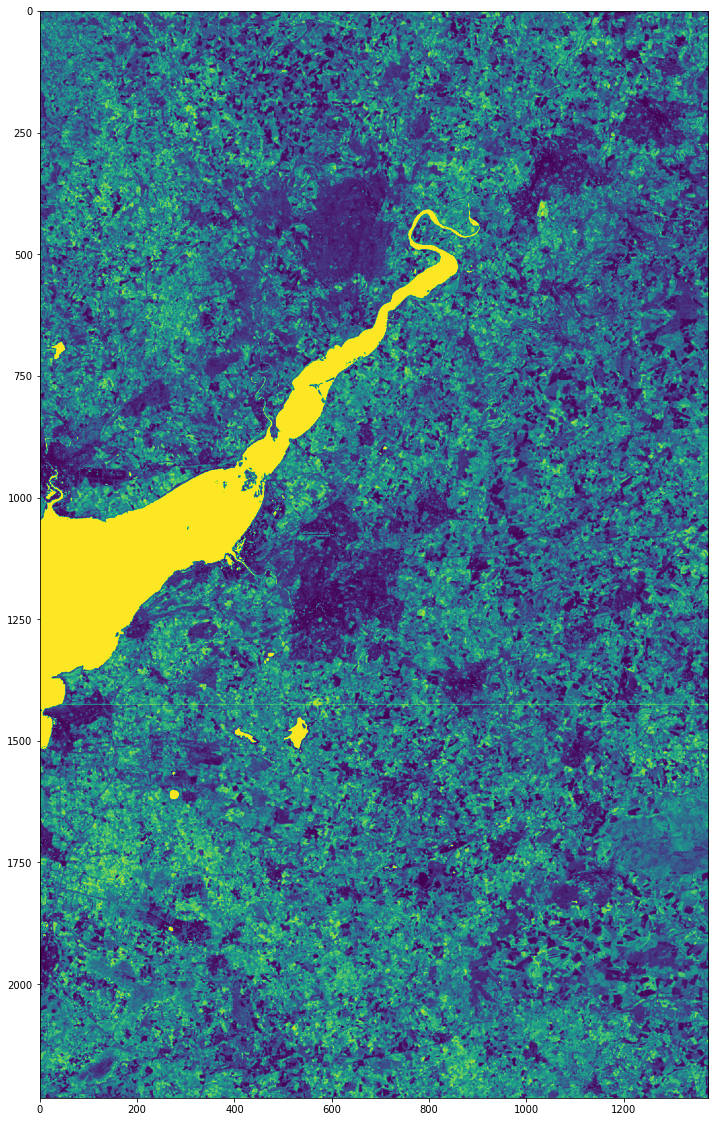

In [95]:
import matplotlib.pyplot as plt 

fig,ax = plt.subplots( figsize=(20,20))
ax.imshow( response._df.iloc[ 0 ][ 'default' ][ :, :, 0 ] )

### _Create binary mask mapping forest land cover classes_

In [90]:
 response._df.iloc[ 0 ][ 'default' ][ :, :, 1 ] 

array([[4, 4, 4, ..., 5, 5, 5],
       [4, 4, 4, ..., 5, 5, 5],
       [4, 4, 4, ..., 5, 5, 5],
       ...,
       [5, 5, 5, ..., 5, 5, 5],
       [5, 5, 5, ..., 5, 5, 5],
       [5, 5, 5, ..., 5, 5, 5]], dtype=uint16)

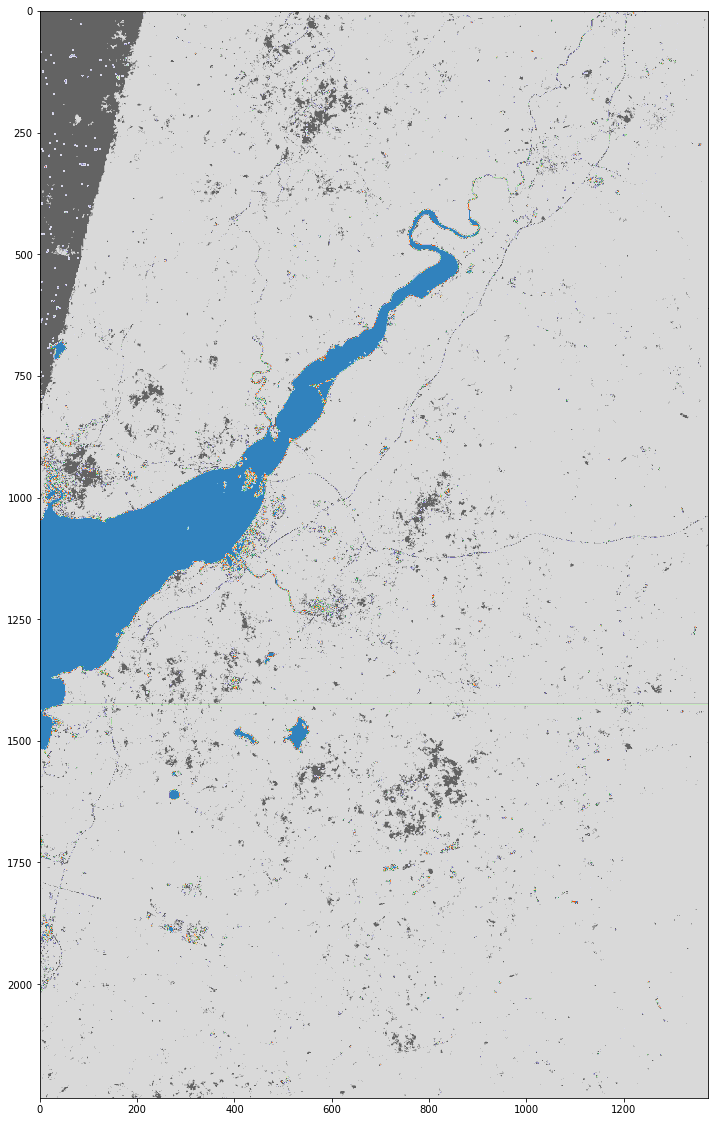

In [91]:
fig,ax = plt.subplots( figsize=(20,20))
ax.imshow( response._df.iloc[ 0 ][ 'default' ][ :, :, 1 ], cmap='tab20c' )

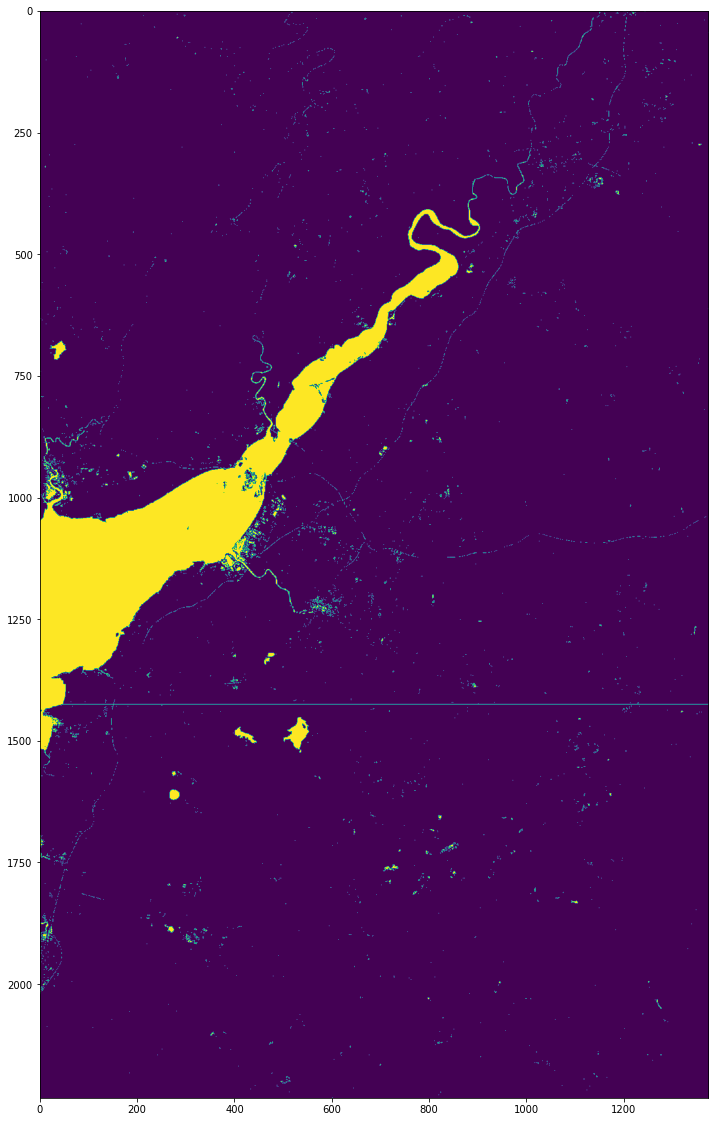

In [94]:
fig,ax = plt.subplots( figsize=(20,20))
ax.imshow( response._df.iloc[ 0 ][ 'default' ][ :, :, 1 ] == 0 )